In [32]:
%matplotlib inline
from ipywidgets import widgets
# [widget for widget in dir(widgets) if widget.endswith('Widget')]

### Importing

In [33]:
import datetime

import os, sys

from multiprocessing import cpu_count
import re
import epr

from scipy.interpolate import RectBivariateSpline
from numpy import linspace, arange, row_stack, delete, round, double
from math import atan

from createMapsEtopo1 import findSubsetIndices
import pygrib

import pyresample as pr
from pyproj import Proj
import distancelib
import gshhs_rasterize

from pylab import *

import simplekml


import ConfigParser
import redis

# sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'cmod'))
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

__author__ = 'Alexander Myasoedov and Denis Spiridonov'

### Default values

In [34]:
pxlRes = None
proj = 'EPSG:3413'

In [35]:
# set the number of CPUs
# numProcs = cpu_count()-2
numProcs = 4
resolution = 75

# redis_conf = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'redis.conf')
redis_conf = os.path.join('/home/mag/Documents/repos/solab/posada/', 'redis.conf')

config = ConfigParser.RawConfigParser()
config.read(redis_conf)
redis_host = config.get('AUTH', 'HOSTNAME')
redis_passwd = config.get('AUTH', 'PASSWORD')

r = redis.Redis(host=redis_host, password=redis_passwd)

### JSON parameter definitions

In [98]:
import json

asarJSON = {}
asarJSON['variables_list'] = ['sigma0', 'wind_speed', 'roughness']
asarJSON['min_max_values']  = {'sigma0':     [-35, 5],
                               'wind_speed': [0, 35],
                               'roughness':  [-1, 1]
                            }
asarJSON['is_masked']  = {'sigma0':     False,
                          'wind_speed': True,
                          'roughness':  False
                        }
asarJSON['polarizations_list'] = ['hh', 'vv', 'hv', 'vh']
# 'u1' (NC_UBYTE)  2**8 =0-255
# 'u2' (NC_USHORT  2**16=0-65535
# 'u4' (NC_UINT)   2**32=0-4294967295
# 'u8' (NC_UINT64) 2**64=0-18446744073709551615
# if 2\two data types are specified-we generate nc tyle pyramid and export data at max resolution to nc file
asarJSON['nc_data_type'] = ['u1', 'u8']

with open('ASAR.json', 'w') as outfile:
    json.dump(asarJSON, outfile, indent=4, separators=(',', ': '), sort_keys=True)

### Func Definitions

In [36]:
def windDirection(u, v):
    U = u.ravel()
    V = v.ravel()
    direction = zeros(size(U))
    for i in range(0, len(U)):
        if U[i] >= 0 and V[i] > 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] < 0 and V[i] > 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] >= 0 and V[i] < 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 360)
        if U[i] < 0 and V[i] < 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])))
        if V[i] == 0 and U[i] > 0: direction[i] = 270
        if V[i] == 0 and U[i] < 0: direction[i] = 90
        if V[i] == 0 and U[i] == 0: direction[i] = 0
    return reshape(direction, v.shape)

In [37]:
def PR_Mouche(theta, phi):
    A_0 = 0.00650704
    B_0 = 0.128983
    C_0 = 0.992839
    A_HALF_PI = 0.00782194
    B_HALF_PI = 0.121405
    C_HALF_PI = 0.992839
    A_PI = 0.00598416
    B_PI = 0.140952
    C_PI = 0.992885

    P_0 = A_0 * exp(B_0 * theta) + C_0
    P_HALF_PI = A_HALF_PI * exp(B_HALF_PI * theta) + C_HALF_PI
    P_PI = A_PI * exp(B_PI * theta) + C_PI

    C0 = (P_0 + P_PI + 2 * P_HALF_PI) / 4
    C1 = (P_0 - P_PI) / 2
    C2 = (P_0 + P_PI - 2 * P_HALF_PI) / 4

    P = C0 + C1 * cos(radians(phi)) + C2 * cos(radians(2 * phi))
    return P

In [38]:
def ncepGFSmodel(startTime, lats_2, lons_2):
    """
    NCEP GFS model wind for givven time, lat/lon crop
    """
    ncepGFSmodel = {} # empty dict for ncepGFSmodel

#     iPath_wind = '/nfs1/store/model/ncep/gfs/'
    iPath_wind = '/media/SOLabNFS2/store/model/ncep/gfs/'

    # find the ncep gfs filename to open from ASAR filename
    baseHour = floor((startTime.hour+3/2)/6)*6
    baseHour = min(18, baseHour)
    if startTime.hour-baseHour>1.5:
        forecastHour = 3
    else:
        forecastHour = 0

    if startTime <= datetime.datetime(2014, 8, 19):
        ncepFileName = 'gfs' + startTime.strftime("%Y%m%d") + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour)

        grbs = pygrib.open(iPath_wind + ncepFileName)

        u_wind = None
        v_wind = None

        # wind contains u=u_wind.values[:], Lats=u_wind.latlons()[0], Lons=u_wind.latlons()[1]
        for idx, msg_info in enumerate(grbs.select()):
            if msg_info['short_name'] == '10u':
                u_wind = grbs.message(idx + 1)
            elif msg_info['short_name'] == '10v':
                v_wind = grbs.message(idx + 1)

        u = u_wind.values[:]
        v = v_wind.values[:]
        lats_wind = u_wind.latlons()[0]
        lons_wind = u_wind.latlons()[1]
    else:
        try:
            ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' %(baseHour) + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour) + '.10m.uv.grib2'

            grbs = pygrib.open(iPath_wind + ncepFileName)

            u_wind = grbs.message(1)
            v_wind = grbs.message(2)
            u = u_wind['values']
            v = v_wind['values']
            lats_wind = u_wind['latitudes']
            lons_wind = u_wind['longitudes']
            lons_wind = reshape(lons_wind, (lons_wind.shape[0]/720, 720))
            lats_wind = reshape(lats_wind, (lats_wind.shape[0]/720, 720))
        except Exception:
            ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' %(baseHour) + '/gfs.t' + '%.2d' %(baseHour) + 'z.pgrb2.0p25.f' + '%.3d' %(forecastHour)

            grbs = pygrib.open(iPath_wind + ncepFileName)

            u_wind = grbs.message(1)
            v_wind = grbs.message(2)
            u = u_wind['values']
            v = v_wind['values']
            lats_wind = u_wind['latitudes']
            lons_wind = u_wind['longitudes']
            lons_wind = reshape(lons_wind, (lons_wind.shape[0]/1440, 1440))
            lats_wind = reshape(lats_wind, (lats_wind.shape[0]/1440, 1440))

    #Make sure the longitude is between -180.00 .. 179.9
    lons_wind = map(lambda x : (lons_wind.ravel()[x]+180)-int((lons_wind.ravel()[x]+180)/360)*360-180, range(0,lons_wind.size))
    lons_wind = reshape(lons_wind, lats_wind.shape)
    # plt.close('all')
    # plt.imshow(lons_wind)
    # plt.colorbar()

#     #Make sure the latitudes is between -90.00 .. 89.9, starting from North - positive
#     lats_wind = map(lambda x : (lats_wind.ravel()[x]+90)-int((lats_wind.ravel()[x]+90)/180)*180-90, xrange(0,lats_wind.size))
#     lats_wind = reshape(lats_wind, lons_wind.shape)
#     if lats_wind[0,0] < lats_wind[-1,-1]:
#         lats_wind = flipud(lats_wind)
#         u = flipud(u)
#         v = flipud(v)
#     plt.close('all')
#     plt.imshow(lats_wind)
#     plt.colorbar()


    # find subset
    res = findSubsetIndices(lats_2.min(),lats_2.max(),lons_2.min(),lons_2.max(),lats_wind[:,0],lons_wind[0,:])
    # expand subset by 1 pixel for better further pyresample
    res[0]=res[0]-2
    res[1]=res[1]+2
    res[2]=res[2]-2
    res[3]=res[3]+2

    # crop the data
    u = u[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    v = v[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lats_wind'] = lats_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lons_wind'] = lons_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]

    ncepGFSmodel['wind_dir'] = windDirection(u,v)
    ncepGFSmodel['wind_speed'] = sqrt(u**2 + v**2)
    ncepGFSmodel['u'] = u
    ncepGFSmodel['v'] = v
    ncepGFSmodel['baseHour'] = baseHour
    ncepGFSmodel['forecastHour'] = forecastHour
#     del u_wind, v_wind
    return ncepGFSmodel

In [39]:
def create_KML(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    # minx, miny, maxx, maxy
    pol.outerboundaryis.coords = [(min(area_extent[0], area_extent[2]),
                                   min(area_extent[1], area_extent[3])),
                                  (max(area_extent[0], area_extent[2]),
                                   max(area_extent[1], area_extent[3]))]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

In [40]:
def swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc', lonlim=(-180,180), latlim=(-90,90), ellps="WGS84", res=111.2e3, lat_ts=None, lat_0=None, lon_0=None):
    """
    Convert given swath coordinates to pyresample area definition.
    The arguments are standard for Proj:
    name
    proj
    lonlim
    latlim
    ellipsoid
    resolution(meters)
    lat_ts (latitude of true scale)
    lat_0,lon_0 is central point
    EXAMPLE:

    epsg3426 is the default one
    for epsg3413:
    swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=111.2e3, lat_ts=70, lat_0=90, lon_0=-45)

    """

    up    = max(latlim)
    down  = min(latlim)
    left  = min(lonlim)
    right = max(lonlim)

    print 'up, down, left, right: ', round(up), round(down), round(left), round(right)

    area_id = name.replace(" ", "_").lower()
    proj_id = area_id

    if proj == 'eqc':
        p = Proj(proj=proj, llcrnrlat=up, urcrnrlat=down, llcrnrlon=left, urcrnrlon=right, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+llcrnrlat=' + str(up) + ' ' + \
             '+urcrnrlat=' + str(down) + ' ' + \
             '+llcrnrlon=' + str(left) + ' ' + \
             '+urcrnrlon=' + str(right) + ' ' + \
             '+ellps=' + str(ellps)
    elif lat_ts!=None and lat_0!=None:
        # lat_ts is latitude of true scale.
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, lat_ts=lat_ts, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+lat_ts=' + str(lat_ts) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0!=None and lat_0!=None and lat_ts==None:
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0==None and lat_0==None and lat_ts==None:
        # lon_0,lat_0 is central point.
        lat_0 = (up + down) / 2
        lon_0 = (right + left) / 2
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)

    left_ex1, up_ex1 = p(left, up)
    right_ex1, up_ex2 = p(right, up)
    left_ex2, down_ex1 = p(left, down)
    right_ex2, down_ex2 = p(right, down)

    if proj == 'stere':
        lon = (left+right)/2.0
        if (lon >=0 and lon <90) or (lon >=-360 and lon < -270):
            print 11111111111
            area_extent = (
                           min(left_ex1, left_ex2, right_ex1, right_ex2),
                           min(down_ex1, down_ex2, up_ex1, up_ex2),
                           max(left_ex1, left_ex2, right_ex1, right_ex2),
                           max(down_ex1, down_ex2, up_ex1, up_ex2)
                        )
        elif (lon >=90 and lon <180) or (lon >=-270 and lon < -180):
            print 2222222222222
            area_extent = (
                           max(left_ex1, left_ex2, right_ex1, right_ex2),
                           max(down_ex1, down_ex2, up_ex1, up_ex2),
                           min(left_ex1, left_ex2, right_ex1, right_ex2),
                           min(down_ex1, down_ex2, up_ex1, up_ex2)
                        )
        elif (lon >= 180 and lon < 270) or (lon >= -180 and lon < -90):
            print 333333333333
            area_extent = (
                           min(left_ex1, left_ex2, right_ex1, right_ex2),
                           min(down_ex1, down_ex2, up_ex1, up_ex2),
                           max(left_ex1, left_ex2, right_ex1, right_ex2),
                           max(down_ex1, down_ex2, up_ex1, up_ex2)
                        )
        else:
            print 44444444444444444
            area_extent = (
                           min(left_ex1, left_ex2, right_ex1, right_ex2),
                           min(down_ex1, down_ex2, up_ex1, up_ex2),
                           max(left_ex1, left_ex2, right_ex1, right_ex2),
                           max(down_ex1, down_ex2, up_ex1, up_ex2)
                        )
    else:
        # минимум из всех координат X, Y, максимум из всех координат X, Y
        # Такой результат даёт правильный area_extent для 3413
        # При этом для 4326 area_extent остаётся неизменным
        # area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', \
        #                                lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=1500, \
        #                                lat_ts=70, lat_0=90, lon_0=-45)
        # Area extent: (-5050747.263141337, 0.0, 0.0, 5050747.263141336)
        area_extent = (
                        min(left_ex1, left_ex2, right_ex1, right_ex2),
                        min(up_ex1, up_ex2, down_ex1, down_ex2),
                        max(left_ex1, left_ex2, right_ex1, right_ex2),
                        max(up_ex1, up_ex2, down_ex1, down_ex2)
                    )

    #~ print 'left: ', left_ex1, left_ex2
    #~ print 'right: ', right_ex1, right_ex2
    #~ print 'up: ', up_ex1, up_ex2
    #~ print 'down: ', down_ex1, down_ex2

#     Using abs() to avoid negative numbers of coloumns/rows as for epsg3413 for example
    xsize = abs(int((area_extent[2] - area_extent[0]) / res[0]))
    ysize = abs(int((area_extent[3] - area_extent[1]) / res[1]))

    swath_area_def = pr.utils.get_area_def(area_id, name, proj_id, proj4_args, xsize, ysize, area_extent)

#     print swath_area_def

    return swath_area_def

In [41]:
def imresize(image, size):
    """
    Resizes coefficient arrays using bivariate spline approximation.
    """
    m, n = image.shape
    X = linspace(0, m - 1, size[0])
    Y = linspace(0, n - 1, size[1])
    kx, ky = min([m - 1, 3]), min([n - 1, 3])
    interp = RectBivariateSpline(
        arange(m), arange(n), image, kx=kx, ky=ky)
    resized = interp(X, Y)
    return resized

In [42]:
def _format_extent_spacing(extent, spacing, extmax, midazimuth=False,
                           midrange=False):
    """Format (and check) extent and spacing."""
    # Check extent
    ext = round(extent).flatten()
    if ext.size != 4:
        raise Exception('extent must contain 4 elements')
    if (ext[0:2] < extmax[0:2]).any() or (ext[2:4] > extmax[2:4]).any():
        exttmp = array(ext)
        ext[0:2] = maximum(ext[0:2], extmax[0:2])
        ext[2:4] = minimum(ext[2:4], extmax[2:4])
        print 'Warning : extent is outside SAR image, '+str(exttmp)+\
            ' becomes '+str(ext)
    if (ext[0:2] > ext[2:4]).any():
        raise Exception('extent[0:2] must be less or equal than '+\
                        'extent[2:4]')
    # Check spacing
    spa = round(spacing).flatten()
    if spa.size == 1:
        spa = repeat(spa[0], 2)
    elif spa.size == 2:
        pass
    else:
        raise Exception('spacing must contain 1 or 2 elements')
    if (spa < [1, 1]).any():
        spatmp = array(spa)
        spa = maximum(spa, [1, 1])
        print 'Warning : spacing too small, '+str(spatmp)+' becomes '+\
            str(spa)
    if (spa > ext[2:4]-ext[0:2]).any():
        spatmp = array(spa)
        spa = minimum(spa, ext[2:4]-ext[0:2])
        print 'Warning : spacing too large, '+str(spatmp)+' becomes '+\
            str(spa)
    # Make extent to be spacing modulo
    ext[2:4] -= (ext[2:4]-ext[0:2]) % spa
#     # 1D extent
#     if midazimuth == True:
#         dim = (ext[2]-ext[0]+1)/spa[0]
#         ext[0:3:2] = ext[0] + (dim-1)//2*spa[0] + [0, spa[0]-1]
#     if midrange == True:
#         dim = (ext[3]-ext[1]+1)/spa[1]
#         ext[1:4:2] = ext[1] + (dim-1)//2*spa[1] + [0, spa[1]-1]
    return (ext, spa)

In [43]:
def compute_sigma0(iPath, fileName, pxlRes=800.0):

    print os.path.join(iPath, fileName)
    try:
        product = epr.Product(os.path.join(iPath, fileName))
    except:
        print 'unable to read file'
        return False

    try:
        band = product.get_band('proc_data')
    except epr.EPRValueError:
        print 'unable to get band "proc_data": epr_get_band_id: band not found'
        return False

    sc_w = double(product.get_scene_width())
    sc_h = double(product.get_scene_height())

    print 'sc_w*sc_h = ', sc_w * sc_h
    if sc_w*sc_h > 60000000:
#     if sc_w*sc_h > 30000000:
        print "ASAR Image too large, skipping"
        return False

    # Get lat/lon from geolocation grid
    dataset = product.get_dataset('GEOLOCATION_GRID_ADS')
    fltp_lats = map(
        lambda x:
        dataset.read_record(x).get_field('first_line_tie_points.lats').get_elems(),
        range(dataset.get_num_records())
    )
    lltp_lats = map(
        lambda x:
        dataset.read_record(x).get_field('last_line_tie_points.lats').get_elems(),
        range(dataset.get_num_records())
    )
    fltp_lons = map(
        lambda x:
        dataset.read_record(x).get_field('first_line_tie_points.longs').get_elems(),
        range(dataset.get_num_records())
    )
    lltp_lons = map(
        lambda x:
        dataset.read_record(x).get_field('last_line_tie_points.longs').get_elems(),
        range(dataset.get_num_records())
    )

    fltp_lats = asarray(double(fltp_lats))/1e6
    lltp_lats = asarray(double(lltp_lats))/1e6
    fltp_lons = asarray(double(fltp_lons))/1e6
    lltp_lons = asarray(double(lltp_lons))/1e6

    lats = row_stack((fltp_lats, lltp_lats[-1, :]))
    lons = row_stack((fltp_lons, lltp_lons[-1, :]))

    lats = fliplr(lats)
    lons = fliplr(lons)

    # Find scale to reduce image to the specified resolution
    arrShape =  asarray([sc_w, sc_h])
    _lats = asarray([lats[0,0], lats[-1,-1], lats[0,-1], lats[-1,0]])
    _lons = asarray([lons[0,0], lons[-1,-1], lons[0,-1], lons[-1,0]])
    imageRes = round(mean(asarray(distancelib.getPixelResolution(_lats, \
                                                                 _lons, \
                                                                 arrShape, 'km'))*1e3))
    scale = pxlRes/imageRes

    extMax = (0.,0.,arrShape[0]-1,arrShape[1]-1)
    ext    = (0.,0.,arrShape[0]-1,arrShape[1]-1)

    # Format extent/spacing
    ext, spa = _format_extent_spacing(extent=ext, spacing = scale, extmax=extMax)
    
    # Read data with stepping=spacing
    try:
        raw_counts = band.read_as_array(sc_w, sc_h, xstep=spa[0], ystep=spa[1])
        incident_angle = product.get_band('incident_angle').read_as_array(sc_w, sc_h, xstep=spa[0], ystep=spa[1])
    except epr.EPRValueError:
        print "EPRValueError"
        return False

    
    lats_2 = imresize(lats, raw_counts.shape)
    lons_2 = imresize(lons, raw_counts.shape)

#     if lats.max() <= 35:
#         print "skipping no area overlap"
#         return False

    # Trimming the array by removing zero values from rows and cols
    msk = []
    for m in range(raw_counts.shape[0]):
        if raw_counts[m, :].sum() == 0:
            msk.append(m)
    raw_counts = delete(raw_counts, msk, axis=0)
    lats_2 = delete(lats_2, msk, axis=0)
    lons_2 = delete(lons_2, msk, axis=0)
    incident_angle = delete(incident_angle, msk, axis=0)
    polarization = product.get_sph().get_field('MDS1_TX_RX_POLAR').get_elem()

    msk = []
    for n in range(raw_counts.shape[1]):
        if raw_counts[:, n].sum() == 0:
            msk.append(n)
    raw_counts = delete(raw_counts, msk, axis=1)
    lats_2 = delete(lats_2, msk, axis=1)
    lons_2 = delete(lons_2, msk, axis=1)
    incident_angle = delete(incident_angle, msk, axis=1)

    # Adding Sigma_0
    calibration_constant = \
    product.get_dataset('MAIN_PROCESSING_PARAMS_ADS').read_record(0).get_field('calibration_factors.1.ext_cal_fact').get_elems()
    # sigma0 = 10*log10( raw_counts**2*sin(incident_angle*pi/180)/calibration_constant )
    sigma0 = raw_counts**2*sin(incident_angle*pi/180)/calibration_constant
    
    return sigma0, lats_2, lons_2, incident_angle, polarization

In [44]:
def compute_roughness(sigma0, incident_angle, polarisation):
    """Compute sea surface roughness.

    Parameters
    ----------
    sigma0 : ndarray
        NRCS backscatter.
    incident_angle : ndarray
        Incidence angle in degrees.
    polarisation : str
        'VV' or 'HH' or 'VH' or 'HV'

    Returns
    -------
    roughness: ndarray
    """
    
    # Lee-Wiener filtering blures to much the ASAR scenes, so we use it only for wind field
    # from scipy.signal import wiener
    # sigma0w = wiener(sigma0, mysize=(3,3), noise=None)
    # sigma0w = sigma0

    # # Earlier form Fabrice - simplyfied
    # polarization = product.get_sph().get_field('MDS1_TX_RX_POLAR').get_elem()
    # if polarization == 'H/H':
    #     ph = (2.20495, -14.3561e-2, 11.28e-4)
    #     sigma0_hh_ref = exp( ( ph[0]+incident_angle*ph[1]+incident_angle**2*ph[2])*log(10) )
    #     roughness = sigma0w/sigma0_hh_ref
    # elif polarization == 'V/V':
    #     pv = (2.29373, -15.393e-2, 15.1762e-4)
    #     sigma0_vv_ref = exp( ( pv[0]+incident_angle*pv[1]+incident_angle**2*pv[2])*log(10) )
    #     roughness = sigma0w/sigma0_vv_ref

    # From sar/cerbere
    from cmod_vect import cmod5n_forward as cmod5
    if polarisation == 'VV' or polarisation == 'V/V': # Use cmod5
        sigma0_vv = cmod5(10, 45, incident_angle)
        return sigma0/sigma0_vv
    elif polarisation == 'HH' or polarisation == 'H/H': # Use cmod5 and Thompson polarisation ratio
        sigma0_vv = cmod5(10, 45, incident_angle)
        alpha = 0.7
        polrat = (1 + 2*tan(incident_angle*pi/180)**2)**2 / \
                 (1 + alpha*tan(incident_angle*pi/180)**2)**2
        return sigma0/sigma0_vv*polrat
    elif polarisation == 'VH' or polarisation == 'HV' \
      or polarisation == 'V/H' or polarisation == 'H/V': # Use simple model
        # nrcs_vh_db = 0.580*wsp - 35.652
        # nrcs_vh_lin = 10^(nrcs_vh_db/10.)
        sigma0_cross = 10**((0.58*10-35.652)/10)
        return sigma0/sigma0_cross
    else:
        raise Exception('Unknown polarisation : '+polarisation)

In [45]:
def compute_wind(fileName, sigma0w, lats_2, lons_2, incident_angle, polarization):
    # Adding Model wind
    startTime = datetime.datetime.strptime(fileName[14:29], "%Y%m%d_%H%M%S")
    ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)
    if not ncepGFSmodelWind:
        return False

    # Reprojecting data

    # Pixel resolution
    # we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
    try:
        pxlResWind = asarray(
            distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'],
                                           ncepGFSmodelWind['lons_wind'],
                                           ncepGFSmodelWind['lats_wind'].shape,
                                           'km')
        )
    except IndexError:
        return False
    pxlResSAR = asarray(
        distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km')
    )*1e3
    # Note pxlResWind is in KM, multiply by 1e3 for meters
#    print "ASAR cell resolution, %s m"  % pxlResSAR
#    print "Wind cell resolution, %s km" % pxlResWind

    # reproject NCEP onto ASAR grid before calculations
    # Try both BivariateSpline, griddata and pyresample

    ncep_def = pr.geometry.GridDefinition(lons=ncepGFSmodelWind['lons_wind'],
                                          lats=ncepGFSmodelWind['lats_wind'])
    swath_def = pr.geometry.SwathDefinition(lons=lons_2, lats=lats_2)

    # wind_speed_model_swath = pr.kd_tree.resample_gauss(
    #     ncep_def, ncepGFSmodelWind['wind_speed'].ravel(), swath_def,
    #     radius_of_influence=2*pxlResWind.max()*1e3, neighbours=12,
    #     sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs
    # )
    wind_dir_model_swath = pr.kd_tree.resample_gauss(
        ncep_def, ncepGFSmodelWind['wind_dir'].ravel(), swath_def,
        radius_of_influence=2*pxlResWind.max()*1e3, neighbours=12,
        sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs
    )

    # calculate bearing from initial lats/lons for further wind calculation
    bearing = zeros((lons.shape[0]-1, lons.shape[1]))

    for n in range(0, lons.shape[1]):
        col = ([lats[:-1, n], lons[:-1, n]], [lats[1:, n], lons[1:, n]])
        for m in range(0, lons.shape[0]-1):
            bearing[m][n] = distancelib.bearing(asarray(col[0])[:, m],
                                                asarray(col[1])[:, m])

    # interpolate to raw_counts.shape
    bearing_2 = imresize(bearing, raw_counts.shape)

    # NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
    wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath

    if polarization == 'H/H':
        PR = PR_Mouche(incident_angle, wind_dir_model_swath_rel)
        try:
            from cmod_gpu import rcs2windOpenCl
            wind_speed_asar = rcs2windOpenCl(sar=sigma0w*PR,
                                             windir=wind_dir_model_swath_rel,
                                             theta=incident_angle)
        except Exception:
            from cmod_vect import rcs2windPar
            wind_speed_asar = rcs2windPar(sigma0w*PR, cmdv=5,
                                          windir=wind_dir_model_swath_rel,
                                          theta=incident_angle,
                                          nprocs=numProcs)
    elif polarization == 'V/V':
        try:
            from cmod_gpu import rcs2windOpenCl
            wind_speed_asar = rcs2windOpenCl(sar=sigma0w,
                                             windir=wind_dir_model_swath_rel,
                                             theta=incident_angle)
        except Exception:
            from cmod_vect import rcs2windPar
            wind_speed_asar = rcs2windPar(sigma0w, cmdv=5,
                                          windir=wind_dir_model_swath_rel,
                                          theta=incident_angle,
                                          nprocs=numProcs)
    
    return wind_speed_asar

### Setting paths

In [46]:
asar_path = '/nfs1/store/satellite/asar/'
_dir = '/nfs1/store/satellite/asar/2010/270'
fileName = 'ASA_WSM_1PNPDK20100927_195408_000000862093_00200_44843_3688.N1'

input_filename = os.path.join(_dir, fileName)
dt = datetime.datetime.strptime(
    fileName[14:22], '%Y%m%d'
).timetuple()
year = str(dt.tm_year)
day = str(dt.tm_yday)

if len(day) == 1:
    day = '00' + day
elif len(day) == 2:
    day = '0' + day
print "Year: %s / Day: %s"  % (year, day)

Year: 2010 / Day: 270


### Sigma0 calculations

In [54]:
print "Calculating sigma0......."

sigma0, lats_2, lons_2, incident_angle, polarization = compute_sigma0(_dir, fileName, pxlRes=resolution)
# roughness = compute_roughness(sigma0, incident_angle, polarization)
# wind_speed_asar = compute_wind(fileName, sigma0, lats_2, lons_2, incident_angle)

Calculating sigma0.......
/nfs1/store/satellite/asar/2010/270/ASA_WSM_1PNPDK20100927_195408_000000862093_00200_44843_3688.N1
sc_w*sc_h =  42706440.0


### Reprojecting and Masking


#### Get first guess pixel resolution

In [59]:
print "Getting first guess pixel resolution from Image......."

# Pixel resolution 
# we use pxlRes for further GSHHS rasterizing and
# reprojecting data with pyresample

lonlim = (lons_2.min(), lons_2.max())
latlim = (lats_2.min(), lats_2.max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)

pxlRes = asarray(
    distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km')
)*1e3
pxlResDeg = asarray(
    distancelib.getPixelResolution(lats_2, lons_2,lons_2.shape, 'deg')
)

print "       S1 cell resolution, %s deg" % str(pxlResDeg)
print "       S1 cell resolution, %s m" % str(pxlRes)

Getting first guess pixel resolution.......
       S1 cell resolution, [ 0.00067087  0.00067192] deg
       S1 cell resolution, [ 74.54672018  74.66426762] m


#### Define areas

In [60]:
print "Defining areas......."

# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(
    lons=lons_2, lats=lats_2
)

# for proj in ['EPSG:4326', 'EPSG:3413']:
# for proj in ['EPSG:4326']:
print "    reprojecting to %s" % proj
if proj == 'EPSG:4326':
    area_def = swath_area_def(name='Temporal SWATH EPSG Projection 4326',
                              proj='eqc',
                              lonlim=lonlimGSHHS,
                              latlim=latlimGSHHS, ellps="WGS84",
                              res=pxlRes)
    # Set the parameters for GSHHS masking
    area_def.proj_ = '4326'
    area_def.proj_name = None
    area_def.units = 'deg'
elif proj == 'EPSG:3413':
    area_def = swath_area_def(name='Temporal SWATH EPSG Projection 3413',
                              proj='stere',
                              lonlim=lonlimGSHHS,
                              latlim=latlimGSHHS, ellps="WGS84",
                              res=pxlRes,
                              lat_ts=70, lat_0=90, lon_0=-45)
    # Set the parameters for GSHHS masking
    area_def.proj_ = '+units=m +ellps=WGS84 +lon_0=-45 +proj=stere +lat_ts=70 +lat_0=90'
    area_def.proj_name = '3413'
    area_def.units = 'm'

Defining areas.......
    reprojecting to EPSG:3413
up, down, left, right:  62.0 55.0 19.0 30.0
11111111111


#### Recalculating Pixel resolution

In [62]:
print "Recalculating Pixel resolution......."

# Get the SAR pixel resolution from the area_def
# for further identical shapes
up = min(latlimGSHHS)
down = max(latlimGSHHS)
left = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def.shape

pxlResDeg = asarray(
    (abs(area_extent_deg[2] - area_extent_deg[0]) /
        float(area_extent_deg_shape[1]),
     abs(area_extent_deg[3] - area_extent_deg[1]) /
        float(area_extent_deg_shape[0]))
)

pxlRes = asarray(
    (area_def.pixel_size_x, area_def.pixel_size_y)
)
print "       S1 cell resolution, %s deg" % str(pxlResDeg)
print "       S1 cell resolution, %s m" % str(pxlRes)

Recalculating Pixel resolution.......
       S1 cell resolution, [ 0.00079377  0.00059095] deg
       S1 cell resolution, [ 74.54778935  74.66929764] m


#### Reprojecting non msked arrays

In [63]:
print "Reprojecting data to new projection(s)......."

sigma0_res = pr.kd_tree.resample_nearest(
    swath_def, sigma0.ravel(), area_def,
    radius_of_influence=4*pxlRes.max(),
    epsilon=0.5, fill_value=None, nprocs=numProcs
)

Reprojecting data to new projection(s).......


In [ ]:
# if mask = True:
    
# else:
    

#### Masking (only for Wind and Roughness)

In [ ]:
print "Masking......."

# Apply Mask from GSHHS
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'
lakes = True

# Doesn't work for now using 4326 and then pyresampling
# mask_arr_3413 = gshhs_rasterize.gshhs_rasterize(
#     lonlimGSHHS, latlimGSHHS,
#     area_def, lakes, shapefile)

print "       Rasterizing Land Mask"

# Rasterizing Land Mask
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(
    lonlimGSHHS, latlimGSHHS, pxlResDeg, True, shapefile)

print "       Reprojecting GSHHS raster onto swath grid"

# reproject GSHHS onto swath grid before calculations
mask_arr_swath = pr.kd_tree.resample_nearest(
    area_def_4326, mask_arr_4326.ravel(), swath_def,
    radius_of_influence=4*pxlRes.max(), epsilon=0.5,
    fill_value=None, nprocs=numProcs
)

# Make masked array
sigma0w = ma.masked_where(mask_arr_swath, sigma0)



#### Reprojecting masked arrays

In [52]:
print "Reprojecting masked data to new projection(s)......."

sigma0w_res = pr.kd_tree.resample_nearest(
    swath_def, sigma0w[p], area_def_3413,
    radius_of_influence=4*pxlRes.max(), epsilon=0.5, fill_value=None
)

Reprojecting masked data to new projection(s).......


NameError: name 'sigma0w' is not defined

### Create NC tiles

In [64]:
# def create_nc_tiles(inpath, fn, out_dir, scale=1):
print "Creating NC tiles......."

import Tiles
reload(Tiles)

from Tiles.nctiles import create_nc_tiles

nc_path = os.path.join('/home/mag/Documents/repos/solab/PySOL/notebooks/pySAR/', fileName[:-3]+'.nc')
if os.path.isfile(nc_path):
    os.remove(nc_path)
# if not os.path.isdir(os.path.dirname(nc_path)):
#     os.makedirs(os.path.dirname(nc_path))

# set Polarization formatting to comply with standards
p = polarization.lower().replace('/', '')
create_nc_tiles(sigma0_res, 'sigma0', nc_path, p)

Creating NC tiles.......
zoom_level:  6
Start zoom level 6

Start zoom level 5

Start zoom level 4

Start zoom level 3

Start zoom level 2

Start zoom level 1

Start zoom level 0



6

### Interactive Plotting

In [25]:
# %matplotlib inline

def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='bone', crop='[:,:]', dimNum=0):
    # check if data type is dictionary and there is no wind
    if type(data) == dict and all(k!='wind_speed' for k in data.iterkeys()):
        plt.figure(figsize=(8,8*double(data[p].shape[0])/double(data[p].shape[1])))
        plt.imshow(eval("data[p]"+str(crop)), vmin=vmi, vmax=vma)
    elif type(data) == dict and any(k=='wind_speed' for k in data.iterkeys()):
        plt.figure(figsize=(8,8*double(data[p].shape[0])/double(data[p].shape[1])))
        X,Y = meshgrid( arange(0,eval("data[p]"+str(crop)).shape[1]),arange(0,eval("data[p]"+str(crop)).shape[0]) )
        U = (data['u'])
        V = (data['v'])
        U = eval("U"+str(crop))
        V = eval("V"+str(crop))
        scl = 100
        plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])
        plt.imshow(eval("data[p]"+str(crop)), vmin=vmi, vmax=vma)
        plt.axis('tight')
    elif type(data) != dict and len(data.shape)>2:
        plt.figure(figsize=(8,8*double(data[:,:,0].shape[0])/double(data[:,:,0].shape[1])))
        plt.imshow(eval("data[:,:,"+str(dimNum)+"]"+str(crop)), vmin=vmi, vmax=vma)
    elif type(data) != dict:
        plt.figure(figsize=(8,8*double(data.shape[0])/double(data.shape[1])))
        plt.imshow(eval("data"+str(crop)), vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)    


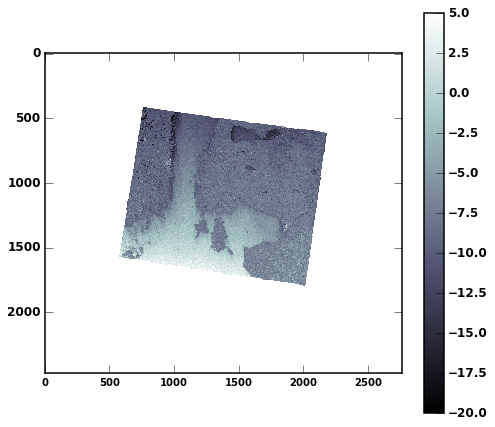

In [26]:
scale = 1
data = 10*log10(sigma0)[::scale,::scale]
data = 10*log10(sigma0_res)[::scale,::scale]

ntrctv = widgets.interact(ntrctv_imshow, \
                          vmi=widgets.FloatSlider(min=-30, max=10, value=-20, step=1), \
                          vma=widgets.FloatSlider(min=-30, max=10, value=5, step=1), \
                          cmap = ['Greys_r', 'bone', 'RdBu_r'], crop = '[:,:]', \
                          dimNum=['0']);

#### OLD VERSION with big_image png tiles